# Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import re

## load and visualize data

In [2]:
data=loadmat("ex8data1.mat")

In [3]:
X = data["X"]
Xval = data["Xval"]
yval = data["yval"]

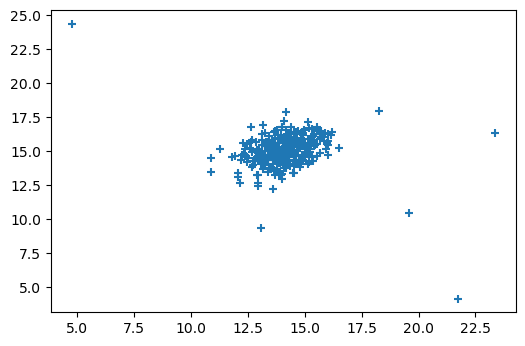

In [4]:
plt.figure(dpi=100)
plt.scatter(X[:,0],X[:,1],marker ="+")
plt.show()

# Gaussian distribution

<img src="anomaly_detection_gaussian_distribution.PNG" width="400" height="200">

# Estimating parameters for a Gaussian

In [5]:
np.var(X,axis=0)

array([1.83263141, 1.70974533])

<img src="anomaly_detection_mean.PNG" width="200" height="150">
<img src="anomaly_detection_variance.PNG" width="200" height="150">

In [6]:
def estimateGaussian(X):
    mu = np.mean(X,axis=0)
    sigma = np.var(X,axis=0)
    return mu,sigma

In [7]:
mu, sigma2 = estimateGaussian(X)

In [8]:
def multivariateGaussian(X, mu, Sigma2): 
    k = len(mu)
    #If Sigma2 is a matrix, it is treated as the covariance matrix. If Sigma2 is a vector, it is treated ,
    #as the \sigma^2 values of the variances in each dimension (a diagonal covariance matrix)

    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)
    else:
        Sigma2
    X = X - mu
    p = 1 / np.sqrt( ((2*np.pi)**k)*(np.linalg.det(Sigma2))) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(Sigma2) * X ,axis=1 ))
    return p

In [9]:
p = multivariateGaussian(X,mu,sigma2)

In [10]:
def visualizeFit(x, mu, sigma2):
    plt.figure(dpi=130)
    plt.scatter(X[:,0],X[:,1],marker ="+")
    A, B = np.meshgrid(x[:,0], x[:,1])
    p2 = multivariateGaussian(np.hstack((A.flatten().reshape(-1,1),B.flatten().reshape(-1,1))),mu,sigma2)
    p2 = p2.reshape(-1,1).reshape(A.shape)
    contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)])[0]
    plt.contour(A,B,p2,contour_level)
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")

In [11]:
x1 = np.arange(0, 30 , 0.1)
x2 = np.arange(0, 30 , 0.1)
X2 = np.hstack((x1.flatten().reshape(-1,1),x2.flatten().reshape(-1,1)))

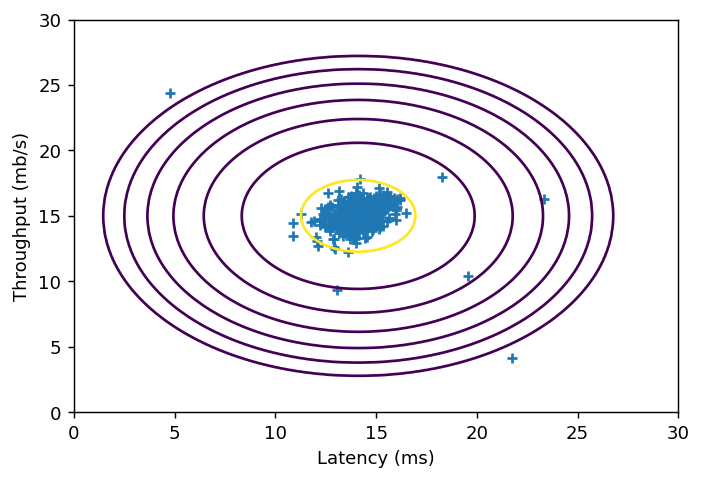

In [12]:
visualizeFit(X2, mu, sigma2)

# EXTRA - GAUSSIAN MODEL WITH COVARIANCE MATRIX TO ADD CORRELATION BETWEEN FEATURES

### calculate covariance matrix

In [13]:
X_cov = X - X.mean(axis=0)
cov_matrix = (1 / (X_cov.shape[0]-1)) * (X_cov.T @ X_cov)  ; cov_matrix

array([[ 1.83862041, -0.22786456],
       [-0.22786456,  1.71533273]])

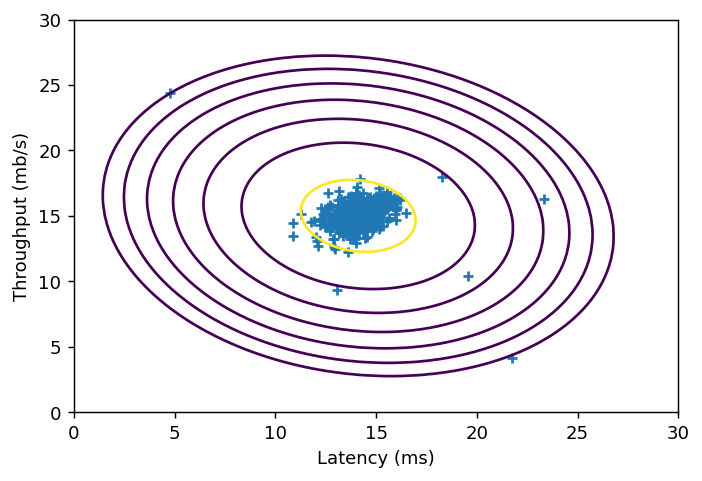

In [14]:
p_cov = multivariateGaussian(X,mu,cov_matrix)
visualizeFit(X2, mu, cov_matrix)

# Selecting the threshold

### visualize labeled validation data

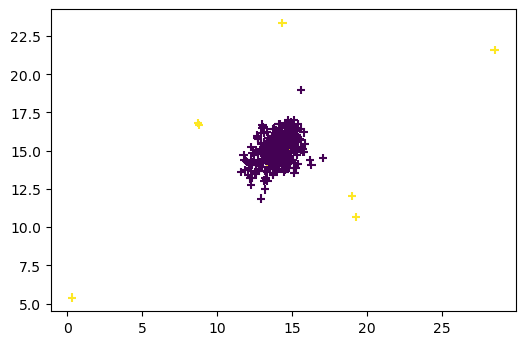

In [15]:
plt.figure(dpi=100)
plt.scatter(Xval[:,0],Xval[:,1],marker ="+",c=yval)
plt.show()

In [16]:
pval = multivariateGaussian(Xval,mu,sigma2)

<img src="anomaly_detection_f1_score.PNG" width="200" height="150">
<img src="anomaly_detection_prec_recall.PNG" width="200" height="150">

In [17]:
def selectThreshold(yval, pval):
    """ finds the best threshold to use for selecting outliers based on the 
    results from a validation set (pval) and the ground truth (yval). """
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(pval) - min(pval)) / 1000
    ep_range = np.arange(min(pval), max(pval),stepsize )
    for epsilon in ep_range:
        pred = pval < epsilon
        pred = pred.reshape(-1,1)
        
        tp = np.sum((pred==1) & (yval == 1))
        fp = np.sum((pred==1) & (yval == 0))
        fn = np.sum((pred==0) & (yval == 1))
        
        prec = tp / (tp+fp)
        rec = tp / (tp+fn)
        
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [18]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

<ipython-input-17-e46dea6122d7>:18: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp+fp)


In [19]:
print('Best epsilon found using cross-validation: {}\n'.format(epsilon))
print('Best F1 on Cross Validation Set:  {}'.format(F1))

Best epsilon found using cross-validation: 8.990852779269495e-05

Best F1 on Cross Validation Set:  0.8750000000000001


In [20]:
"""Find the outliers in the training set and plot the """
outliers = np.where(p < epsilon) ; outliers

(array([300, 301, 303, 304, 305, 306], dtype=int64),)

In [21]:
X[outliers][:,0]

array([13.07931049, 21.72713402, 19.58257277, 23.33986753, 18.26118844,
        4.75261282])

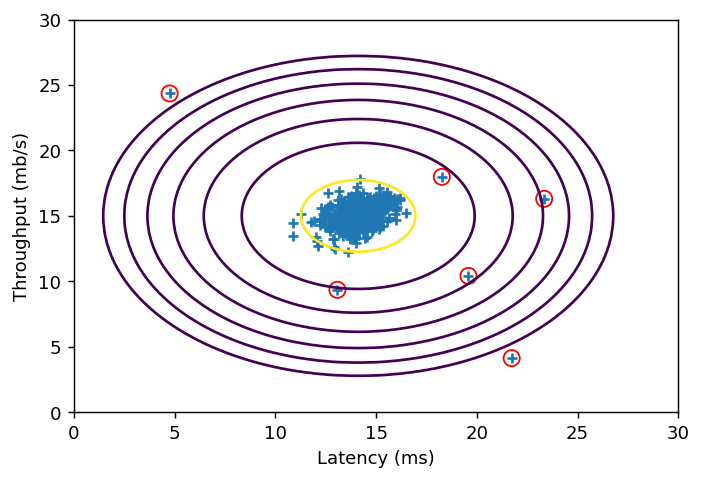

In [22]:
visualizeFit(X2, mu, sigma2)
plt.scatter(X[outliers][:,0], X[outliers][:,1], marker = 'o',facecolor="none",edgecolor="r",s=80)
plt.show()

# High dimensional dataset

In [23]:
data=loadmat("ex8data2.mat")

In [24]:
X = data["X"]
Xval = data["Xval"]
yval = data["yval"]

In [25]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X,mu,sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

<ipython-input-17-e46dea6122d7>:18: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp+fp)


In [26]:
print('Best epsilon found using cross-validation: {}\n'.format(epsilon))
print('Best F1 on Cross Validation Set:  {}\n'.format(F1))
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation: 1.377228890761358e-18

Best F1 on Cross Validation Set:  0.6153846153846154

# Outliers found:  117


# RECOMMENDER SYSTEMS

In [28]:
data=loadmat("ex8_movies.mat")
Y = data["Y"]
R = data["R"]
print('Average rating for movie 1 (Toy Story): {:.2F} / 5'.format(np.mean(Y[0][R[0]==1])))

Average rating for movie 1 (Toy Story): 3.88 / 5


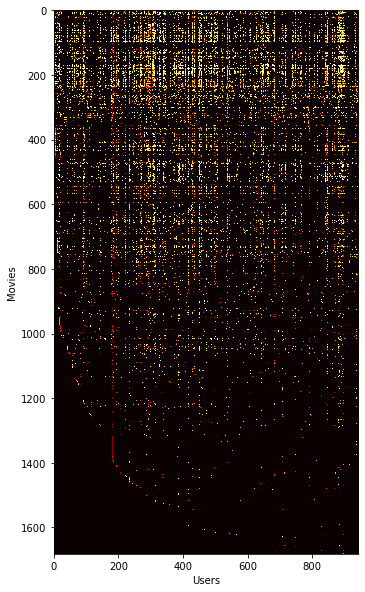

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(Y, cmap='hot', interpolation='nearest')
plt.xlabel("Users")
plt.ylabel("Movies")
plt.show()

# Collaborative filtering learning algorithm

In [30]:
#Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
preTrainedWeights = loadmat('ex8_movieParams.mat');

In [31]:
X = preTrainedWeights["X"]
Theta = preTrainedWeights["Theta"]
num_users=preTrainedWeights["num_users"]
num_movies=preTrainedWeights["num_movies"]
num_features=preTrainedWeights["num_features"]

In [32]:
num_users = 4; num_movies = 5; num_features = 3

In [33]:
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]

In [34]:
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

In [35]:
params = np.hstack((X.flatten(), Theta.flatten()))

                                      COLLABORATIVE FILTERING COST FUNCTION
<img src="collaborative_filtering_cost_function.PNG" width="500" height="300">

                                        COLLABORATIVE FILTERING GRADIENT
<img src="collaborative_filtering_gradient.PNG" width="300" height="200">

                                  REGULARIZED COLLABORATIVE FILTERING COST FUNCTION
<img src="regularized_cofi_cost_function.PNG" width="500" height="300">

                                  REGULARIZED COLLABORATIVE FILTERING GRADIENT
<img src="regularized_cofi_gradient.PNG" width="500" height="300">

In [36]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    J = (1/2) * np.sum((((X  @ Theta.T ) - Y)**2) * R)
    
    X_grad = (((X  @ Theta.T ) - Y) *  R ) @ Theta
    Theta_grad =  (((X @ Theta.T ) - Y) * R ).T @ X
    
    regularized = (Lambda / 2) * (np.sum(Theta**2) + np.sum(X**2) ) 
    
    J_reg = J + regularized
        
    X_grad_reg = X_grad + (Lambda * X)
    Theta_grad_reg = Theta_grad + (Lambda * Theta)
    
    grad_reg = np.hstack((X_grad_reg.flatten(), Theta_grad_reg.flatten()))

    return J_reg, grad_reg

In [37]:
J_reg = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5 )[0]

In [38]:
print('Cost at loaded parameters (lambda = 1.5): {:.2f}'.format(J_reg))

Cost at loaded parameters (lambda = 1.5): 31.34


# Learning movie recommendations

In [39]:
# load movie list
movieList = open("movie_ids.txt","r").read().split("\n")[:-1]

In [40]:
movieList

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [41]:
# Initialize my ratings
my_ratings = np.zeros((1682, 1))

In [42]:
# Check the file movie_idx.txt for id of each movie in our dataset
# example, Toy Story (1995) has ID 1, "4"so to rate it , you can set
my_ratings[0] = 4
# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2
# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

In [43]:
print("new_user ratings\n") 
for i in range (len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.format(my_ratings[i], movieList[i]))

new_user ratings

Rated [4.] for 1 Toy Story (1995)
Rated [3.] for 7 Twelve Monkeys (1995)
Rated [5.] for 12 Usual Suspects, The (1995)
Rated [4.] for 54 Outbreak (1995)
Rated [5.] for 64 Shawshank Redemption, The (1994)
Rated [3.] for 66 While You Were Sleeping (1995)
Rated [5.] for 69 Forrest Gump (1994)
Rated [2.] for 98 Silence of the Lambs, The (1991)
Rated [4.] for 183 Alien (1979)
Rated [5.] for 226 Die Hard 2 (1990)
Rated [5.] for 355 Sphere (1998)


In [44]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, 
    and returns the mean rating in Ymean
    """
    
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    
    for i in range(m):
        idx = np.where(R[i, :]==1)
        Ymean[i] = np.mean(Y[i,idx])
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]
    
    return Ynorm, Ymean

In [45]:
def gradientDescent(params, Y, R, num_users, num_movies, num_features, alpha, num_iters, Lambda):
    
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history = []
    
    for i in range(num_iters):
        
        params = np.hstack((X.flatten(), Theta.flatten()))
                            
        J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)
        
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad  = grad[num_movies*num_features:].reshape(num_users,num_features)
        
        X = X - (alpha * X_grad)
        Theta = Theta - (alpha * Theta_grad)
        J_history.append(J)
                            
    params = np.hstack((X.flatten(), Theta.flatten()))
                        
    return J_history, params

In [48]:
"""After the additional ratings have been added to the dataset, 
the code below will proceed to train the collaborative filtering model. 
This will learn the parameters X and Theta"""

data=loadmat("ex8_movies.mat")
Y = data["Y"]
R = data["R"]

# Add our own ratings to the data matrix
Y = np.append(my_ratings, Y, axis=1)
R = np.append((my_ratings != 0), R, axis=1)

# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#useful values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.hstack((X.flatten(), Theta.flatten()))

# Set Regularization
Lambda = 10
alpha = 0.001
num_iters = 500

In [49]:
J_history, params = gradientDescent(initial_parameters, Ynorm, R, num_users, num_movies, num_features, alpha, num_iters, Lambda )

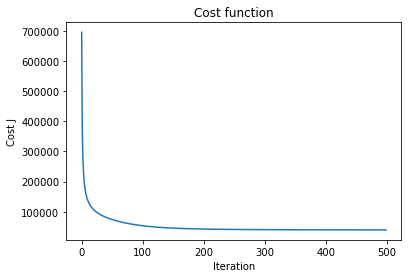

In [54]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost J")
plt.title("Cost function")
plt.show()

In [51]:
# Unfold the returned theta back into U and W
X = params[:num_movies*num_features].reshape(num_movies,num_features)
Theta = params[num_movies*num_features:].reshape(num_users,num_features)

In [52]:
# predict ratings
p = X @ Theta.T

# add mean 
my_predictions = p[:,0].reshape(-1,1)+ Ymean
recommendations = np.append(np.array(movieList).reshape(-1,1),my_predictions,axis=1 )
recommendations = pd.DataFrame(recommendations)
recommendations["index"] = recommendations[0].map(lambda x: re.findall('^\S*',x))
recommendations["index"] = recommendations["index"].map(lambda x: str(x)[1:-1])
recommendations[0] = recommendations[0].map(lambda x: re.sub('^\S*','',x))
recommendations = recommendations.sort_values(by=1,ascending=False)

In [53]:
for i in range(10):
    if i == 0:
        print('\nTop recommendations for you:\n')
    else:    
        print('Predicting rating {:.2f} for movie {}'.format(float(recommendations.iloc[i,1]),  recommendations.iloc[i,0]))


Top recommendations for you:

Predicting rating 5.00 for movie  Someone Else's America (1995)
Predicting rating 5.00 for movie  Aiqing wansui (1994)
Predicting rating 5.00 for movie  Star Kid (1997)
Predicting rating 5.00 for movie  Saint of Fort Washington, The (1993)
Predicting rating 5.00 for movie  Great Day in Harlem, A (1994)
Predicting rating 5.00 for movie  Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.00 for movie  Prefontaine (1997)
Predicting rating 5.00 for movie  They Made Me a Criminal (1939)
Predicting rating 5.00 for movie  Santa with Muscles (1996)
